# Random Agent 

This is a random agent as implemented in examples provided [here](https://gitlab.aicrowd.com/flatland/flatland/blob/master/examples/training_example.py) by the Flatland challenge creators 

In [1]:
import numpy as np

from flatland.envs.observations import TreeObsForRailEnv, LocalObsForRailEnv
from flatland.envs.predictions import ShortestPathPredictorForRailEnv
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import complex_rail_generator
from flatland.envs.schedule_generators import complex_schedule_generator
from flatland.utils.rendertools import RenderTool

In [2]:
np.random.seed(1)

# Use the complex_rail_generator to generate feasible network configurations with corresponding tasks
# Training on simple small tasks is the best way to get familiar with the environment
N_agents = 1

TreeObservation = TreeObsForRailEnv(max_depth=2, predictor=ShortestPathPredictorForRailEnv())
LocalGridObs = LocalObsForRailEnv(view_height=10, view_width=2, center=2)
rail_generator = complex_rail_generator(nr_start_goal=10, nr_extra=2, min_dist=8, max_dist=99999, seed=1)
env = RailEnv(width=20, height=20,
              rail_generator= rail_generator,
              schedule_generator=complex_schedule_generator(), 
              number_of_agents=N_agents, 
              obs_builder_object=TreeObservation)
env.reset()

env_renderer = RenderTool(env)

In [3]:
# Import your own Agent or use RLlib to train agents on Flatland
# As an example we use a random agent here
class RandomAgent:

    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

    def act(self, state):
        """
        :param state: input is the observation of the agent
        :return: returns an action
        """
        return np.random.choice(np.arange(self.action_size))

    def step(self, memories):
        """
        Step function to improve agent by adjusting policy given the observations

        :param memories: SARS Tuple to be
        :return:
        """
        return

    def save(self, filename):
        # Store the current policy
        return

    def load(self, filename):
        # Load a policy
        return

In [4]:
# Initialize the agent with the parameters corresponding to the environment and observation_builder
agent = RandomAgent(218, 5)
n_trials = 20

# Empty dictionary for all agent action
action_dict = dict()
print("Starting Training...")

Starting Training...


In [5]:
all_scores = []
for trials in range(1, n_trials + 1):

    # Reset environment and get initial observations for all agents
    obs, info = env.reset()
    for idx in range(env.get_num_agents()):
        tmp_agent = env.agents[idx]
        tmp_agent.speed_data["speed"] = 1 / (idx + 1)
    env_renderer.reset()
    # Here you can also further enhance the provided observation by means of normalization
    # See training navigation example in the baseline repository

    score = 0
    # Run episode
    for step in range(50):
        # Chose an action for each agent in the environment
        for a in range(env.get_num_agents()):
            action = agent.act(obs[a])
            action_dict.update({a: action})
        # Environment step which returns the observations for all agents, their corresponding
        # reward and whether their are done
        next_obs, all_rewards, done, _ = env.step(action_dict)
        # note that rendering significantly slows down the average run time
        # consider commenting the rendering command for a faster run
        # env_renderer.render_env(show=True, show_observations=True, show_predictions=False)

        # Update replay buffer and train agent
        for a in range(env.get_num_agents()):
            agent.step((obs[a], action_dict[a], all_rewards[a], next_obs[a], done[a]))
            score += all_rewards[a]
        obs = next_obs.copy()
        if done['__all__']:
            break
    all_scores.append(score)        
    print('\rEpisode Nr. {}\t Score = {}'.format(trials, score), end = "")

Episode Nr. 20	 Score = -33.0

In [6]:
avg = np.mean(all_scores)
print('average score of a random agent over {} episodes is {}'.format(n_trials, avg))

average score of a random agent over 20 episodes is -43.6


## Random Agent with renderer without background embellishments

This is to check that the renderer works fine even after removing background embellishments

In [7]:
import numpy as np
import io
import os
import time
from collections import deque
#import tkinter as tk

from flatland.envs.observations import TreeObsForRailEnv, LocalObsForRailEnv
from flatland.envs.predictions import ShortestPathPredictorForRailEnv
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import complex_rail_generator
from flatland.envs.schedule_generators import complex_schedule_generator
from flatland.utils.rendertools import RenderTool

In [8]:
from PIL import Image, ImageDraw, ImageFont
from numpy import array
from pkg_resources import resource_string as resource_bytes

from flatland.utils.graphics_layer import GraphicsLayer

from flatland.core.grid.rail_env_grid import RailEnvTransitions 

from flatland.utils.graphics_pil import PILGL, PILSVG

In [9]:
np.random.seed(1)

# Use the complex_rail_generator to generate feasible network configurations with corresponding tasks
# Training on simple small tasks is the best way to get familiar with the environment
N_agents = 1

TreeObservation = TreeObsForRailEnv(max_depth=2, predictor=ShortestPathPredictorForRailEnv())
LocalGridObs = LocalObsForRailEnv(view_height=10, view_width=2, center=2)
rail_generator = complex_rail_generator(nr_start_goal=10, nr_extra=2, min_dist=8, max_dist=99999, seed=1)
env = RailEnv(width=20, height=20,
              rail_generator= rail_generator,
              schedule_generator=complex_schedule_generator(), 
              number_of_agents=N_agents, 
              obs_builder_object=TreeObservation)
env.reset()

env_renderer = RenderTool(env)

In [10]:
def set_rail_at_new(self, row, col, binary_trans, target=None, is_selected=False, rail_grid=None, num_agents=None,
                show_debug=True):
    
    if binary_trans in self.pil_rail:
        pil_track = self.pil_rail[binary_trans]
        if target is not None:
            target_img = self.station_colors[target % len(self.station_colors)]
            target_img = Image.alpha_composite(pil_track, target_img)
            self.draw_image_row_col(target_img, (row, col), layer=PILGL.TARGET_LAYER)
            if show_debug:
                self.text_rowcol((row + 0.8, col + 0.0), strText=str(target), layer=PILGL.TARGET_LAYER)

        city_size = 1
        if num_agents is not None:
            city_size = max(1, np.log(1 + num_agents) / 2.5)

        self.draw_image_row_col(pil_track, (row, col), layer=PILGL.RAIL_LAYER)
    else:
        print("Illegal rail:", row, col, format(binary_trans, "#018b")[2:], binary_trans)

    if target is not None:
        if is_selected:
            svgBG = self.pil_from_png_file('flatland.png', "Selected_Target.png")
            self.clear_layer(PILGL.SELECTED_TARGET_LAYER, 0)
            self.draw_image_row_col(svgBG, (row, col), layer=PILGL.SELECTED_TARGET_LAYER)

In [11]:
import types

In [12]:
funcType = types.MethodType
env_renderer = RenderTool(env)
env_renderer.gl.set_rail_at = funcType(set_rail_at_new, env_renderer.gl)

In [13]:
# Import your own Agent or use RLlib to train agents on Flatland
# As an example we use a random agent here
class RandomAgent:

    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

    def act(self, state):
        """
        :param state: input is the observation of the agent
        :return: returns an action
        """
        return np.random.choice(np.arange(self.action_size))

    def step(self, memories):
        """
        Step function to improve agent by adjusting policy given the observations

        :param memories: SARS Tuple to be
        :return:
        """
        return

    def save(self, filename):
        # Store the current policy
        return

    def load(self, filename):
        # Load a policy
        return

In [14]:
# Initialize the agent with the parameters corresponding to the environment and observation_builder
agent = RandomAgent(218, 5)
n_trials = 5000

# Empty dictionary for all agent action
action_dict = dict()
print("Starting Training...")

Starting Training...


In [15]:
all_scores = []
for trials in range(1, n_trials + 1):

    # Reset environment and get initial observations for all agents
    obs, info = env.reset()
    for idx in range(env.get_num_agents()):
        tmp_agent = env.agents[idx]
        tmp_agent.speed_data["speed"] = 1 / (idx + 1)
    env_renderer.reset()
    # Here you can also further enhance the provided observation by means of normalization
    # See training navigation example in the baseline repository

    score = 0
    scores_window = deque(maxlen = 100) # scores of last 100 episodes
    # Run episode
    for step in range(500):
        # Chose an action for each agent in the environment
        for a in range(env.get_num_agents()):
            action = agent.act(obs[a])
            action_dict.update({a: action})
        # Environment step which returns the observations for all agents, their corresponding
        # reward and whether their are done
        next_obs, all_rewards, done, _ = env.step(action_dict)
        # note that rendering significantly slows down the average run time
        # consider commenting the rendering command for a faster run
        # env_renderer.render_env(show=True, show_observations=True, show_predictions=False)

        # Update replay buffer and train agent
        for a in range(env.get_num_agents()):
            agent.step((obs[a], action_dict[a], all_rewards[a], next_obs[a], done[a]))
            score += all_rewards[a]
        obs = next_obs.copy()
        if done['__all__']:
            break
    all_scores.append(score)
    scores_window.append(score)
    print('\rEpisode Nr. {}\tScore = {}\tAverage Score: {:.2f}'.format(trials, score, np.mean(scores_window)), end="")

Episode Nr. 5000	Score = -124.0	Average Score: -124.00

In [16]:
avg = np.mean(all_scores)
print('average score of a random agent over {} episodes is {}'.format(n_trials, avg))

average score of a random agent over 5000 episodes is -272.2512


In [17]:
import matplotlib.pyplot as plt

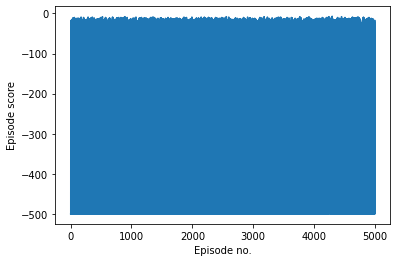

In [18]:
plt.figure()
plt.plot(range(1,len(all_scores)+1), all_scores )
plt.xlabel("Episode no.")
plt.ylabel("Episode score")
plt.show()

We can see that the scores are uniformly distributed between 0 and 500. The expectation value of the random uniform distribution over an interval (a,b) is given by (b+a)/2. In our case we therefore expect the avg. score to be (0+500)/2 = 250.0. The avg. score we found experimentally was ~ 272 which not too far from the theoretical expectation value for the score. 

This seems to work fine!